## Introduction

When trying to find answers to complex problems, experiments can often elucidate an answer.
However, these experiments can sometimes be cost-prohibitive or simply too risky to conduct.
In these cases, simulation may be preferable to traditional experiments.

One type of simulation, called discrete event simulation, is particularly relevant and is the focus of this post.
In discrete event simulation, the simulation environment skips forward in time from one event to the next.
This is in contrast to real time simulation, where time progresses forward smoothly.

Imagine a simulation of a bus stop, where one guest arrives every five to ten seconds and a bus arrives to pick them up every seven minutes.

- How long will guests need to wait for the bus?
- How sensitive is wait time to the frequency of the bus arrival?
- What if some guests use electric conveyance vehicles (ECVs) and require more time to load and more space on the bus?
- Will any guests have to wait more than 30 minutes for a bus?

A real time simulation would have to calculate the position of various guests and busses at every time until the simulation stopped.
On the other hand, a discrete event simulation would jump forward in time to the next guest arriving or the next bus departing.

Let's try to simulate this example of guests showing up to a bus stop and waiting for a bus.
We will use `simpy` to do the discrete event simulation in Python.

## Describing the simulation in Python

In order to accurately describe this system, we must first think through what a guest would experience.

1. Arrive at the bus stop and wait for a bus to arrive.
1. When the bus arrives, if there are seats available, board the bus. Otherwise, wait for the next one.
1. Ride in the bus to the destination and disembark.

We will start by using Python classes to represent guests and busses, then move on to model the interactions between them.

In [1]:
import numpy as np
import simpy
rng = np.random.default_rng(2024)

class Guest():
    """This class represents guests that wait for the bus"""

    # remember the ID given to the previous guest so we can increment it
    prev_id = 0

    def __init__(self, attributes, wait_time_start):
        # give each guest a unique ID
        self.id = self.__class__.prev_id + 1
        self.__class__.prev_id = self.id
        # give the guest attributes that may affect boarding time
        self.attributes = attributes
        # record the time when this guest started waiting for a bus
        self.wait_time_start = wait_time_start

class Bus():
    """This class represents the busses the guests are waiting for"""

    prev_id = 0

    def __init__(self, attributes):
        self.id = self.__class__.prev_id + 1
        self.__class__.prev_id = self.id
        self.attributes = attributes
        self.passengers = []

In the code above, we created classes for the guests and for the busses that will transport the guests.
Now we have to model how they will interact.
While the classes above were defined using standard Python, the processes by which instances of these classes will interact must be defined using Simpy.
First, let's have some guests arrive.
Then, some busses can arrive too.

In [2]:
def guests_arrive(env, guest_queue):
    while True:
        # Wait between 5 and 10 seconds in the simulation
        yield env.timeout(rng.integers(5,11))
        # there's a 2% chance the guest uses an ECV
        attributes = {'ecv': rng.choice([False, True], p=[0.98, 0.02])}
        # create the guest
        guest = Guest(attributes, wait_time_start=env.now)
        print(f"{env.now}\tGuest {guest.id} arrived. ECV={attributes['ecv']}.")
        # add the guest to the queue
        guest_queue.put(guest)

def busses_arrive(env, bus_queue):
    while True:
        # wait 7 minutes in the simulation
        yield env.timeout(7*60)
        # half of the busses have 40 seats and half of the busses have 50 seats
        attributes = {'seats': rng.choice([40,50])}
        # create the bus
        bus = Bus(attributes)
        print(f"{env.now}\tBus {bus.id} with {attributes['seats']} seats arrived.")
        # add the bus to the queue
        bus_queue.put(bus)


Next we have to define the process by which guests load on to the bus.
We need to get a bus (if one exists), then guests can load onto it, with some guests potentially taking more time than others.
After the bus is full it should depart.
Let's code it.

In [3]:
def loading_zone(env, bus_queue, guest_queue, wait_times):
    while True:
        # get a bus from the queue
        bus = yield bus_queue.get()
        print(f"{env.now}\tLoading bus {bus.id}")
        # make sure we are not over capacity on the bus
        num_seats = bus.attributes['seats']
        while len(bus.passengers) < num_seats:
            # get a passenger from the queue
            guest = yield guest_queue.get()
            print(f"{env.now}\tGuest{guest.id} is loading onto bus {bus.id}.")
            # ECVs take longer to load and take the space of 3 non-ECV riders.
            if guest.attributes['ecv']:
                # 2 min to load guest
                yield env.timeout(2*60)
                # account for size of ECV
                num_seats -=2
            else:
                # 1 s timeout
                yield env.timeout(1)
            # add guest to passenger list
            bus.passengers.append(guest)
            # record [current time, time that the guest had to wait to board]
            wait_times.append([env.now, env.now-guest.wait_time_start])
        print(f"{env.now}\t bus {bus.id} is departing the loading zone with guests {bus.passengers[0].id} to {bus.passengers[-1].id}.")

Everything is defined so we are ready to run the simulation in Simpy!

In [4]:
# List to hold all wait times of guests that boarded
wait_times = []
# initialize the simulation environment
env = simpy.Environment()
# Establish the guest queue as a Simpy Store
guest_queue = simpy.Store(env)
# Establish the bus queue as a Simpy Store
bus_queue = simpy.Store(env)
# Implement the process for guests arriving
env.process(guests_arrive(env, guest_queue))
# Implement the process for busses arriving
env.process(busses_arrive(env, bus_queue))
# Implement the process for busses being loaded
env.process(loading_zone(env, bus_queue, guest_queue, wait_times))

env.run(60*60*3)

6	Guest 1 arrived. ECV=False.
15	Guest 2 arrived. ECV=False.
25	Guest 3 arrived. ECV=True.
34	Guest 4 arrived. ECV=False.
44	Guest 5 arrived. ECV=False.
49	Guest 6 arrived. ECV=False.
55	Guest 7 arrived. ECV=False.
61	Guest 8 arrived. ECV=False.
71	Guest 9 arrived. ECV=False.
76	Guest 10 arrived. ECV=False.
82	Guest 11 arrived. ECV=False.
89	Guest 12 arrived. ECV=False.
97	Guest 13 arrived. ECV=False.
105	Guest 14 arrived. ECV=False.
114	Guest 15 arrived. ECV=False.
121	Guest 16 arrived. ECV=False.
130	Guest 17 arrived. ECV=False.
136	Guest 18 arrived. ECV=False.
143	Guest 19 arrived. ECV=False.
149	Guest 20 arrived. ECV=False.
158	Guest 21 arrived. ECV=False.
165	Guest 22 arrived. ECV=False.
173	Guest 23 arrived. ECV=False.
179	Guest 24 arrived. ECV=False.
186	Guest 25 arrived. ECV=False.
193	Guest 26 arrived. ECV=False.
199	Guest 27 arrived. ECV=False.
204	Guest 28 arrived. ECV=False.
210	Guest 29 arrived. ECV=False.
220	Guest 30 arrived. ECV=False.
225	Guest 31 arrived. ECV=False.
2

## Interpreting the output

So the bad news is that Simpy doesn't automatically export useful information about the simulation, but the good news is that we can set up our code to record any information about the simulation that we want to.
The various print statements included in the code above are useful for debugging, but parsing the more than 2000 lines of output would not be an efficient use of time.
Instead, we added a property to each guest in the simulation that recorded the time that they entered the queue.
When the guest boarded the bus, we recorded the current simulation time as well as the total time that the guest waited in the line.
Now we can simply plot the wait times vs. simulation time and see that after two hours (7200 s) of simulation, the line gets so backed up that almost every guest is waiting for more than 30 minutes for a bus!

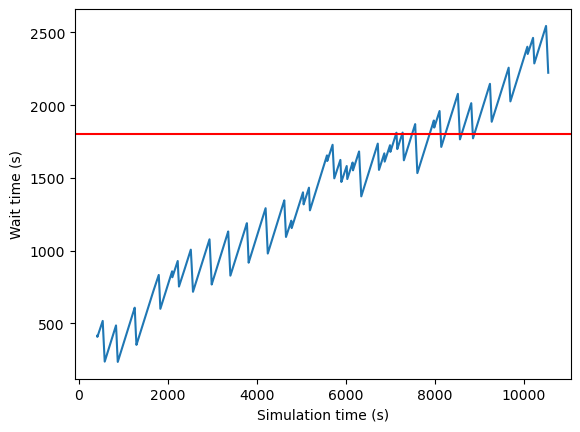

In [5]:
import matplotlib.pyplot as plt
wt = np.array(wait_times)
plt.figure()
plt.plot(wt[:,0], wt[:,1])
plt.axhline(60*30, c='r')
plt.xlabel('Simulation time (s)')
plt.ylabel('Wait time (s)')
plt.show()

## Fixing the wait time
If our goal is to ensure that no guest waits over 30 minutes, we may want to increase the frequency of busses arriving to the loading zone.
We can easily do this by redefining the `busses_arrive` function.
Let's see what happens when we have busses arrive every 5 minutes instead...

9	Guest 1451 arrived. ECV=False.
15	Guest 1452 arrived. ECV=False.
20	Guest 1453 arrived. ECV=False.
29	Guest 1454 arrived. ECV=False.
34	Guest 1455 arrived. ECV=False.
43	Guest 1456 arrived. ECV=False.
53	Guest 1457 arrived. ECV=False.
58	Guest 1458 arrived. ECV=False.
68	Guest 1459 arrived. ECV=False.
73	Guest 1460 arrived. ECV=False.
79	Guest 1461 arrived. ECV=False.
87	Guest 1462 arrived. ECV=False.
94	Guest 1463 arrived. ECV=False.
100	Guest 1464 arrived. ECV=False.
107	Guest 1465 arrived. ECV=False.
112	Guest 1466 arrived. ECV=False.
120	Guest 1467 arrived. ECV=False.
128	Guest 1468 arrived. ECV=False.
135	Guest 1469 arrived. ECV=False.
140	Guest 1470 arrived. ECV=False.
148	Guest 1471 arrived. ECV=False.
157	Guest 1472 arrived. ECV=False.
167	Guest 1473 arrived. ECV=False.
175	Guest 1474 arrived. ECV=False.
180	Guest 1475 arrived. ECV=False.
188	Guest 1476 arrived. ECV=False.
198	Guest 1477 arrived. ECV=False.
207	Guest 1478 arrived. ECV=False.
214	Guest 1479 arrived. ECV=False.

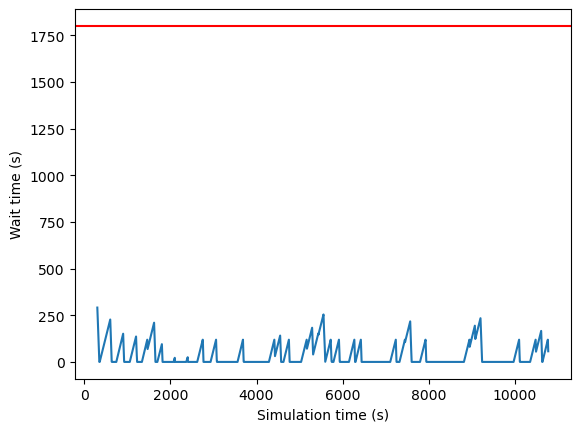

In [6]:
def busses_arrive(env, bus_queue):
    while True:
        # wait 5 minutes in the simulation
        yield env.timeout(5*60)
        # half of the busses have 40 seats and half of the busses have 50 seats
        attributes = {'seats': rng.choice([40,50])}
        # create the bus
        bus = Bus(attributes)
        print(f"{env.now}\tBus {bus.id} with {attributes['seats']} seats arrived.")
        # add the bus to the queue
        bus_queue.put(bus)

# List to hold all wait times of guests that boarded
wait_times = []
# initialize the simulation environment
env = simpy.Environment()
# Establish the guest queue as a Simpy Store
guest_queue = simpy.Store(env)
# Establish the bus queue as a Simpy Store
bus_queue = simpy.Store(env)
# Implement the process for guests arriving
env.process(guests_arrive(env, guest_queue))
# Implement the process for busses arriving
env.process(busses_arrive(env, bus_queue))
# Implement the process for busses being loaded
env.process(loading_zone(env, bus_queue, guest_queue, wait_times))

env.run(60*60*3)

wt = np.array(wait_times)
plt.figure()
plt.plot(wt[:,0], wt[:,1])
plt.axhline(60*30, c='r')
plt.xlabel('Simulation time (s)')
plt.ylabel('Wait time (s)')
plt.show()

Awesome! Five minutes between bus arrivals keeps guest wait time to an average of 42 seconds, with many guests able to just walk right on a bus.
While this post only scratches the surface with regards to what's possible with discrete event simulation, I hope you found it useful.

In [7]:
wt[:,1].mean()

42.869565217391305